# **Brain tumor dectector**

The goal of this project is to detect when there is a tumor on a MRI image.

## **Load libraries**

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [39]:
tf.__version__

'2.12.0'

## **GPU configurations**

In [40]:
!nvidia-smi

Wed May 10 22:11:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   1887MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,
         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

## **Load data**

**Note**: The dataset is on Google Drive. So I will load it from there. I you want to load yours from another source, specify it instead of using Google drive.

In [42]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [43]:
import os

os.listdir('/gdrive/MyDrive/dataset')

['no', 'yes']

**no** is for **no tumor images** and **yes** for **tumor images**.

In [44]:
from tensorflow.keras.utils import image_dataset_from_directory


train_ds = image_dataset_from_directory(
    '/gdrive/MyDrive/dataset',
    image_size=(300, 300),
    subset='training',
    validation_split=0.2,
    batch_size=16,
    seed=42,
    color_mode='rgb',
    label_mode='binary'
)

valid_ds = image_dataset_from_directory(
    '/gdrive/MyDrive/dataset',
    image_size=(300, 300),
    subset='validation',
    validation_split=0.2,
    batch_size=16,
    seed=42,
    color_mode='rgb',
    label_mode='binary'
)

Found 253 files belonging to 2 classes.
Using 178 files for training.
Found 253 files belonging to 2 classes.
Using 75 files for validation.


In [45]:
#Split valid_ds into validation_ds and test_ds, 50% each.
size = tf.data.experimental.cardinality(valid_ds)

validation_ds = valid_ds.take(size//2)
test_ds = valid_ds.skip(size//2)

Let's take a look to the images of the dataset.

In [46]:
label_names = {0: 'no tumor', 1: 'tumor'}

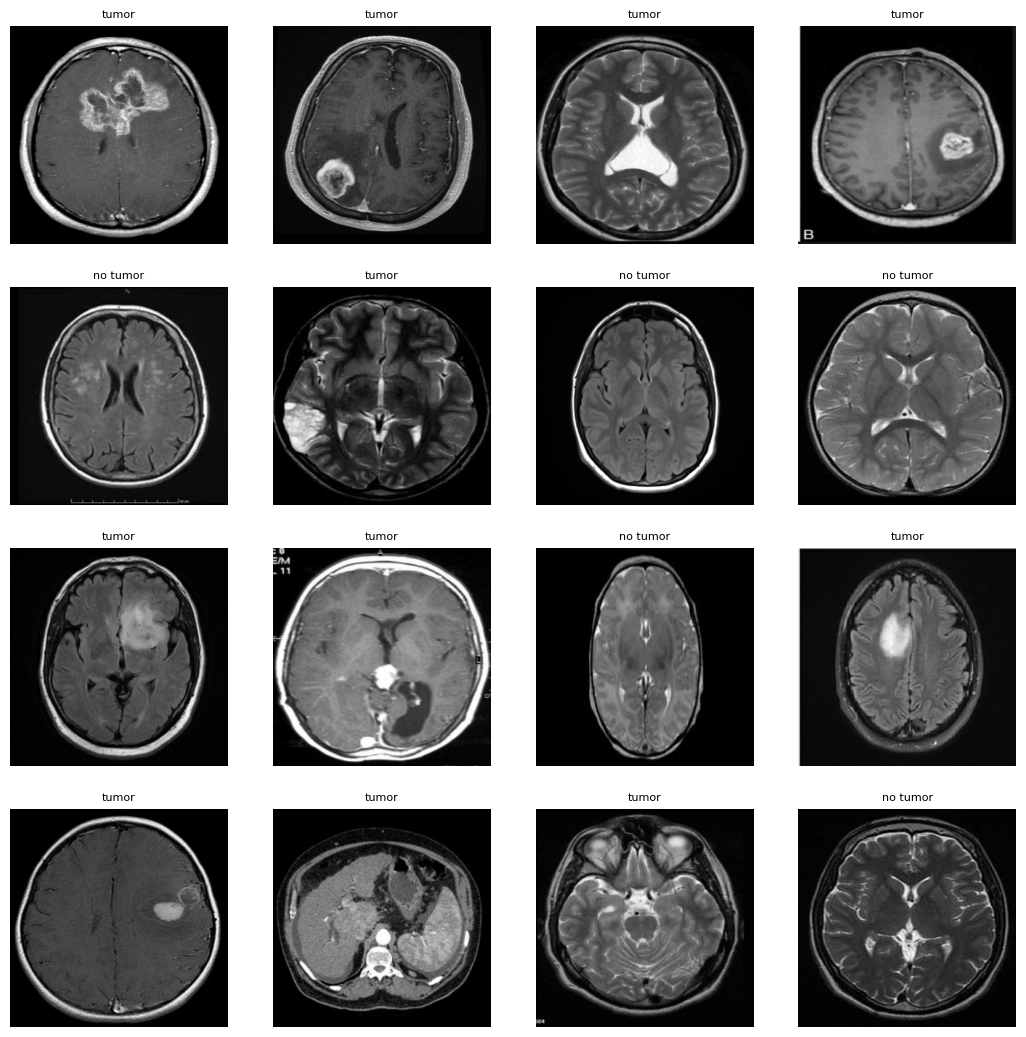

In [47]:
import matplotlib.colors as colors

plt.figure(figsize=(13,13))
for i, (image, label) in enumerate(train_ds.unbatch().take(16)):
    ax = plt.subplot(4, 4, i + 1)
    image = colors.Normalize()(image)
    plt.imshow(image)
    plt.title(label_names[np.max(label.numpy())], fontdict={'fontsize': 8})
    plt.axis('off')

# **Training**

In [48]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
])

In [49]:
# You should configure the filepath if you use a local directory.

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/gdrive/MyDrive/brain_tumor_detector_v1.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 35, 35, 64)      

In [51]:
model.compile(
    optimizer='rmsprop',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [52]:
epochs = 25

history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/25
12/12 [==============================] - 5s 79ms/step - loss: 21.8336 - binary_accuracy: 0.6067 - val_loss: 1.0130 - val_binary_accuracy: 0.7188
Epoch 2/25
12/12 [==============================] - 1s 60ms/step - loss: 0.5563 - binary_accuracy: 0.7640 - val_loss: 0.4121 - val_binary_accuracy: 0.8125
Epoch 3/25
12/12 [==============================] - 1s 53ms/step - loss: 0.9027 - binary_accuracy: 0.7247 - val_loss: 1.6871 - val_binary_accuracy: 0.6250
Epoch 4/25
12/12 [==============================] - 1s 52ms/step - loss: 0.7586 - binary_accuracy: 0.7079 - val_loss: 0.7190 - val_binary_accuracy: 0.7500
Epoch 5/25
12/12 [==============================] - 1s 53ms/step - loss: 0.3686 - binary_accuracy: 0.8596 - val_loss: 0.7353 - val_binary_accuracy: 0.6562
Epoch 6/25
12/12 [==============================] - 1s 52ms/step - loss: 0.3399 - binary_accuracy: 0.8483 - val_loss: 2.8506 - val_binary_accuracy: 0.4688
Epoch 7/25
12/12 [==============================] - 1s 52ms/step - lo

In [53]:
# Evaluate the model on the test dataset
load_model = keras.models.load_model('/gdrive/MyDrive/brain_tumor_detector_v1.keras')
test_loss, test_acc = load_model.evaluate(test_ds)
print(f'Binary accuracy [test]: {test_acc:.3f}')

3/3 [==============================] - 1s 172ms/step - loss: 1.2979 - binary_accuracy: 0.7674
Binary accuracy [test]: 0.767


# **Look at training metrics**

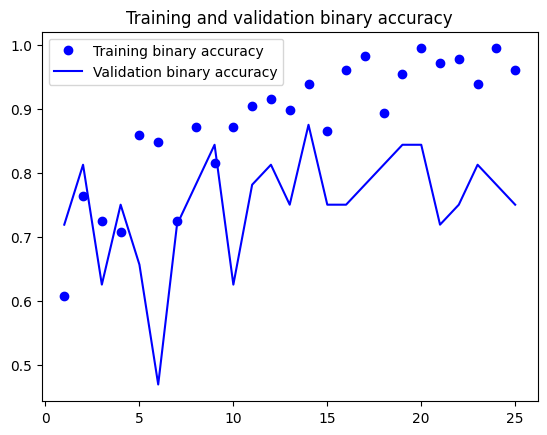

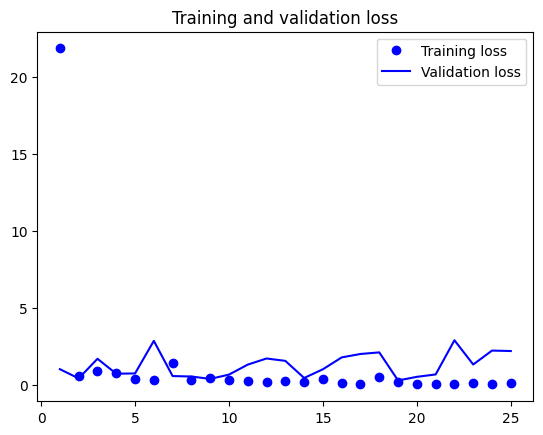

In [54]:
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training binary accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation binary accuracy')
plt.title('Training and validation binary accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()